# 네트워크 커뮤니티 탐지

이 노트북에서는 여러 알고리즘을 사용해 커뮤니티 탐지를 수행하는 몇 가지 방법을 탐구한다.

알고리즘을 테스트하기 전에 간단한 벤치마크 그래프를 생성한다.

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import networkx as nx 
G = nx.barbell_graph(m1=10, m2=4) 

### 행렬 분해

몇 가지 행렬 분해 기술을 사용해 임베딩을 추출하는 것으로 시작한다.

이 임베딩을 시각화하고 기존 클러스터링 알고리즘으로 클러스터링한다.

In [4]:
from gem.embedding.hope import HOPE 
gf = HOPE(d=4, beta=0.01) 
gf.learn_embedding(G) 
embeddings = gf.get_embedding() 

SVD error (low rank): 0.052092


In [5]:
from sklearn.manifold import TSNE

In [6]:
tsne = TSNE(n_components=2) 

emb2d = tsne.fit_transform(embeddings)

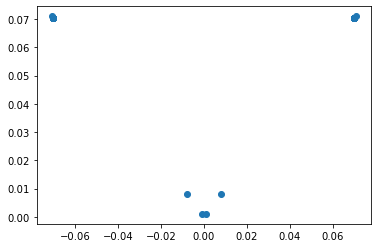

In [8]:
plt.plot(embeddings[:, 0], embeddings[:, 1], 'o', linewidth=0)

GaussianMixture 모델을 사용해 클러스터링한다.

In [9]:
from sklearn.mixture import GaussianMixture

In [10]:
gm = GaussianMixture(n_components=3, random_state=0) #.(embeddings)

In [11]:
labels = gm.fit_predict(embeddings)

In [12]:
colors = ["blue", "green", "red"]

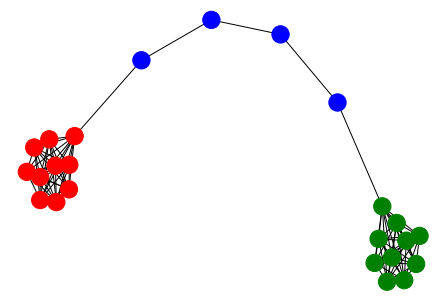

In [13]:
nx.draw_spring(G, node_color=[colors[label] for label in labels])

### 스펙트럼 클러스터링

이제 그래프의 인접 행렬을 기반으로 스펙트럼 클러스터링을 수행한다.

이 클러스터링은 상호 배타적인 클러스터링이 아니며 노드가 둘 이상의 커뮤니티에 속할 수 있다.

In [14]:
adj=np.array(nx.adjacency_matrix(G).todense())

In [15]:
from communities.algorithms import spectral_clustering

communities = spectral_clustering(adj, k=3)

다음 플롯에서는 빨간색을 사용하여 커뮤니티에 속한 노드를 강조 표시했다.

파란색 노드는 지정된 커뮤니티에 속하지 않는 노드를 나타낸다.

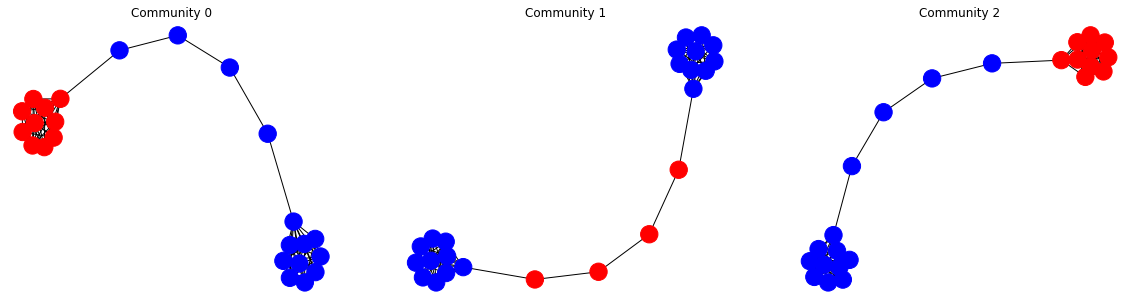

In [16]:
plt.figure(figsize=(20, 5))

for ith, community in enumerate(communities):
    cols = ["red" if node in community else "blue" for node in G.nodes]
    plt.subplot(1,3,ith+1)
    plt.title(f"Community {ith}")
    nx.draw_spring(G, node_color=cols)

다음은 서로 다른 커뮤니티에 속한 노드 ID를 보여준다.

In [17]:
communities

[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9},
 {10, 11, 12, 13},
 {14, 15, 16, 17, 18, 19, 20, 21, 22, 23}]

### 비음수 행렬 분해

여기서 다시 행렬 분해를 사용하지만 비음수 행렬 분해를 사용하고 클러스터를 잠재 차원과 연결한다.

In [18]:
from sklearn.decomposition import NMF

In [19]:
nmf = NMF(n_components=2)

In [20]:
emb = nmf.fit_transform(adj)

C:\Users\K\.conda\envs\Graph_ML_38\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


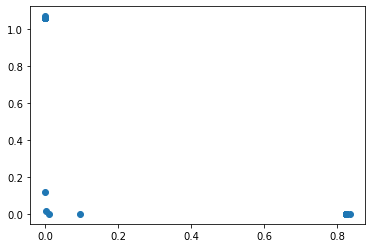

In [21]:
plt.plot(emb[:, 0], emb[:, 1], 'o', linewidth=0)

임계값을 0.01로 주어진 커뮤니티에 속한 노드를 결정한다.

In [22]:
communities = [set(np.where(emb[:,ith]>0.01)[0]) for ith in range(2)]

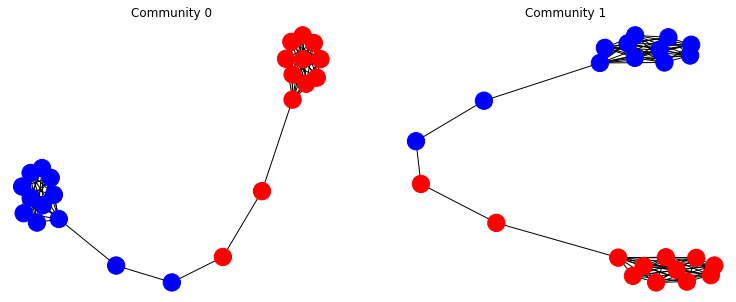

In [23]:
plt.figure(figsize=(20, 5))

for ith, community in enumerate(communities):
    cols = ["red" if node in community else "blue" for node in G.nodes]
    plt.subplot(1,3,ith+1)
    plt.title(f"Community {ith}")
    nx.draw_spring(G, node_color=cols)

위의 예는 이것을 보여주지 않지만 일반적으로 이 클러스터링 방법은 상호 배타적이지 않을 수 있으며 노드는 둘 이상의 커뮤니티에 속할 수 있다.

### 루벤 및 모듈성 최적화

여기서는 상당히 큰 그래프에서도 커뮤니티 탐지를 수행하는 데 가장 널리 사용되는 방법 중 하나인 루벤(Louvain) 방법을 사용한다.
책에서 설명한 것처럼 루벤 방법은 기본적으로 파티셔닝(상호 배타적인 커뮤니티 탐지 알고리즘)을 최적화하고, 같은 커뮤니티에 속한 노드들이 서로 잘 연결되어 있음을 의미하고 다른 커뮤니티와 약하게 연결됨을 모듈성 점수를 최대화하는 것을 식별한다.

**루벤은 다른 커뮤니티 탐지 알고리즘과 달리 커뮤니티의 수를 미리 지정하고 최적의 커뮤니티 수를 찾을 필요가 없다.**

In [24]:
from communities.algorithms import louvain_method
communities = louvain_method(adj)

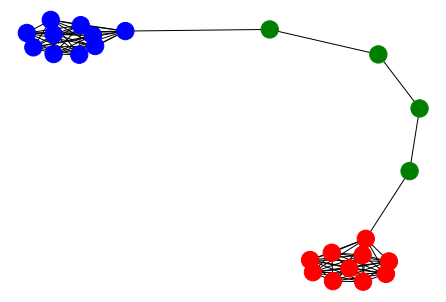

In [25]:
c = pd.Series({node: colors[ith] for ith, nodes in enumerate(communities) for node in nodes}).values
nx.draw_spring(G, node_color=c)

In [26]:
communities

[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9},
 {10, 11, 12, 13},
 {14, 15, 16, 17, 18, 19, 20, 21, 22, 23}]

### 기르반-뉴먼

Girvan-Newman 알고리즘은 원본 그래프에서 간선을 점진적으로 제거하여 커뮤니티를 감지한다.
알고리즘은 각 단계에서 "가장 가치 있는" 간선,
전통적으로 가장 높은 중간 중심성을 갖는 간선을 제거한다.
그래프가 조각조각 나면서 촘촘하게 짜여진 커뮤니티 구조가 노출되고 그 결과를 덴드로그램으로 나타낼 수 있다.

**사이 중심성 계산으로 인해 이 방법은 큰 그래프로 확장하기 어렵다.**

In [27]:
from communities.algorithms import girvan_newman
communities = girvan_newman(adj, n=2)

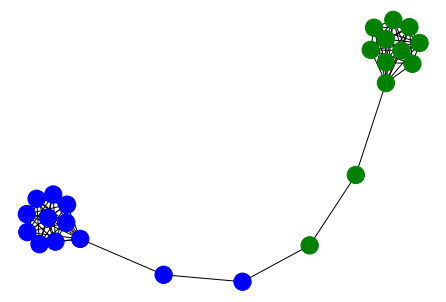

In [28]:
c = pd.Series({node: colors[ith] for ith, nodes in enumerate(communities) for node in nodes}).values
nx.draw_spring(G, node_color=c)

In [29]:
communities

[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11},
 {12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}]